# Predicting Human Development Index 

## 0 Dependencies

In [1]:
import numpy as np
import pandas as pd

import altair as alt 
import matplotlib.pyplot as plt
import seaborn as sns

## 1 Import Data

**Data Sources**

Data is sourced from multiple different pages and tables located on the OurWorldInData website.

- https://ourworldindata.org/mental-health
- https://ourworldindata.org/human-development-index
- https://ourworldindata.org/democracy
- https://ourworldindata.org/food-supply

In [2]:
# load data
data_dir = "data" 
hdi = pd.read_csv(f"{data_dir}/human-development-index.csv")
depression = pd.read_csv(f"{data_dir}/depressive-disorders-prevalence-ihme.csv")
democracy = pd.read_csv(f"{data_dir}/electoral-democracy-index.csv")
food = pd.read_csv(f"{data_dir}/daily-per-capita-caloric-supply.csv")


# inspect datasets here   
food.head()

,Entity,Code,Year,Daily caloric supply (OWID based on UN FAO & historical sources)
0,Afghanistan,AFG,1961,2999.0
1,Afghanistan,AFG,1962,2917.0
2,Afghanistan,AFG,1963,2698.0
3,Afghanistan,AFG,1964,2953.0
4,Afghanistan,AFG,1965,2956.0


## 2 Data Cleaning

### 2.1 Missing Values

Missing values are almost always going to be necessary to check for when dealing with a fresh dataset. 

What you do with those missing values may vary. There are two typical routes for handling missing values:
- **Removal:** Simply remove all the rows missing values. 
- **Imputation:** Replace all missing values with a metric based on that column (i.e. median, mean, ...). Imputation has benefits and consequences, be sure to research first.

In [3]:
# check for missing values in Code column for each dataset 
print('hdi', hdi['Code'].isna().sum())
print('depression', depression['Code'].isna().sum())
print('democracy', democracy['Code'].isna().sum())
print('food', food['Code'].isna().sum())


hdi 320
depression 270
democracy 1893
food 586


In [4]:
# it seems only the Code variable has missing values, inspect to figure out why
democracy[democracy['Code'].isna()]

,Entity,Code,Year,electdem_vdem_owid,electdem_vdem_high_owid,electdem_vdem_low_owid
234,Africa,NaN,1789,0.018800,0.025600,0.010400
235,Africa,NaN,1790,0.018600,0.025600,0.010600
236,Africa,NaN,1791,0.018600,0.025600,0.010600
237,Africa,NaN,1792,0.018600,0.025600,0.010600
238,Africa,NaN,1793,0.018800,0.025600,0.010400
...,...,...,...,...,...,...
26650,South America,NaN,2018,0.686500,0.739583,0.635083
26651,South America,NaN,2019,0.660667,0.714250,0.610167
26652,South America,NaN,2020,0.645333,0.697917,0.597833
26653,South America,NaN,2021,0.657000,0.711667,0.604500


In [5]:
# remove continents and other entities from the datasets
hdi.dropna(subset=['Code'], inplace=True)
depression.dropna(subset=['Code'], inplace=True)
democracy.dropna(subset=['Code'], inplace=True)
food.dropna(subset=['Code'], inplace=True)

print('hdi', hdi['Code'].isna().sum())
print('depression', depression['Code'].isna().sum())
print('democracy', democracy['Code'].isna().sum())
print('food', food['Code'].isna().sum())

hdi 0
depression 0
democracy 0
food 0


### 2.2 Dropping Unnecessary Columns

In [6]:
# drop Code column from each dataset
# drop extra democracy columns, keep the median
hdi.drop(columns=['Code'], inplace=True)
depression.drop(columns=['Code'], inplace=True)
democracy.drop(columns=['Code', 'electdem_vdem_high_owid', 'electdem_vdem_low_owid'], inplace=True)
food.drop(columns=['Code'], inplace=True)

In [7]:
food.head()

,Entity,Year,Daily caloric supply (OWID based on UN FAO & historical sources)
0,Afghanistan,1961,2999.0
1,Afghanistan,1962,2917.0
2,Afghanistan,1963,2698.0
3,Afghanistan,1964,2953.0
4,Afghanistan,1965,2956.0


### 2.3 Renaming Columns

In [8]:
# rename columns to contain simpler names
depression = depression.rename(columns={'Entity': 'Country',
                                        'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depression'})

hdi = hdi.rename(columns={'Entity': 'Country',
                          'Human Development Index': 'HDI'})

democracy = democracy.rename(columns={'Entity': 'Country',
                                      'electdem_vdem_owid': 'Democracy'})

food = food.rename(columns={'Entity': 'Country',
                            'Daily caloric supply (OWID based on UN FAO & historical sources)': 'Food'})

# preview
democracy.head()

,Country,Year,Democracy
0,Afghanistan,1789,0.019
1,Afghanistan,1790,0.019
2,Afghanistan,1791,0.019
3,Afghanistan,1792,0.019
4,Afghanistan,1793,0.019


### 2.4 Narrowing Scope to a Single Year

The datasets contain large ranges of years for each country. Rather than averaging these values out, it probably makes the most sense to take the most recent year from each dataset. 

An alternative to consider in the future is to average all values over the past 10 years, 20 years, etc. . This would introduce more problems as some of the countries probably don't have full date ranges to average, so we will avoid this method for now. 

In [9]:
# write a function to find max year and keep only that year
def max_year(df):
    max_year = df['Year'].max()
    max_year_df = df[df['Year'] == max_year]
    return max_year_df

# apply function to each dataset
hdi = max_year(hdi)
depression = max_year(depression)
democracy = max_year(democracy)
food = max_year(food)

In [10]:
# preview 
food.head()

,Country,Year,Food
57,Afghanistan,2018,2040.0
173,Albania,2018,3360.0
233,Algeria,2018,3322.0
291,Angola,2018,2385.0
349,Antigua and Barbuda,2018,2445.0


In [11]:
# print the year found in each dataset
print('HDI:', hdi['Year'].unique())
print('Depression:', depression['Year'].unique())
print('Democracy:', democracy['Year'].unique())
print('Food:', food['Year'].unique())

HDI: [2021]
Depression: [2019]
Democracy: [2022]
Food: [2018]


### 2.5 Merge the Datasets

In [12]:
# drop the Year column from each dataset as it is no longer needed
hdi = hdi.drop(columns=['Year'])
depression = depression.drop(columns=['Year'])
food = food.drop(columns=['Year'])
democracy = democracy.drop(columns=['Year'])

In [13]:
# merge the datasets
merge = pd.merge(
    hdi, 
    depression, 
    on='Country',
    how='inner' 
).merge(
    food,
    on='Country',
    how='inner'  
).merge(
    democracy,
    on='Country',
    how='inner' 
).dropna()  # drops any rows with missing values

# preview
merge.head()


,Country,HDI,Depression,Food,Democracy
0,Afghanistan,0.478,4.945168,2040.0,0.082
1,Albania,0.796,2.460203,3360.0,0.484
2,Algeria,0.745,4.129681,3322.0,0.281
3,Angola,0.586,5.744194,2385.0,0.344
4,Argentina,0.842,2.407510,3307.0,0.823


In [14]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     157 non-null    object 
 1   HDI         157 non-null    float64
 2   Depression  157 non-null    float64
 3   Food        157 non-null    float64
 4   Democracy   157 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [15]:
# double check null values
merge.isnull().sum(axis=0)

Country       0
HDI           0
Depression    0
Food          0
Democracy     0
dtype: int64

## 3 Data Exploration

### 3.1 Defining Objectives

**Goal:** Build a model for predicting Human Development Index (HDI) using a country's prevalence of depressive disorders, democracy, and caloric supply. 

The model will likely be more interesting if we convert HDI to a factor to increase interpretability. We will then need to use plots to explore the data. Model building should begin with a simple logistic regression model to see initial performance, then move to more complex models through machine learning pipelines to find optimal performance. 

### 3.2 Exploratory Data Plotting

In [16]:
scatter1 = alt.Chart(merge).mark_circle(color='purple').encode(
    x=alt.X('Depression', title='Prevalence of Depression'),
    y=alt.Y('HDI', title='Human Development Index')
).properties(
    title='Depression vs. HDI'
)

scatter2 = alt.Chart(merge).mark_circle(color='green').encode(
    x=alt.X('Food', title='Food Variable'),
    y=alt.Y('HDI', title='Human Development Index')
).properties(
    title='Food vs. HDI'
)

scatter3 = alt.Chart(merge).mark_circle(color='blue').encode(
    x=alt.X('Democracy', title='Democracy Variable'),
    y=alt.Y('HDI', title='Human Development Index')
).properties(
    title='Democracy vs. HDI'
)

# concatenate the plots
scatter_all = scatter1 | scatter2 | scatter3

scatter_all

alt.HConcatChart(...)

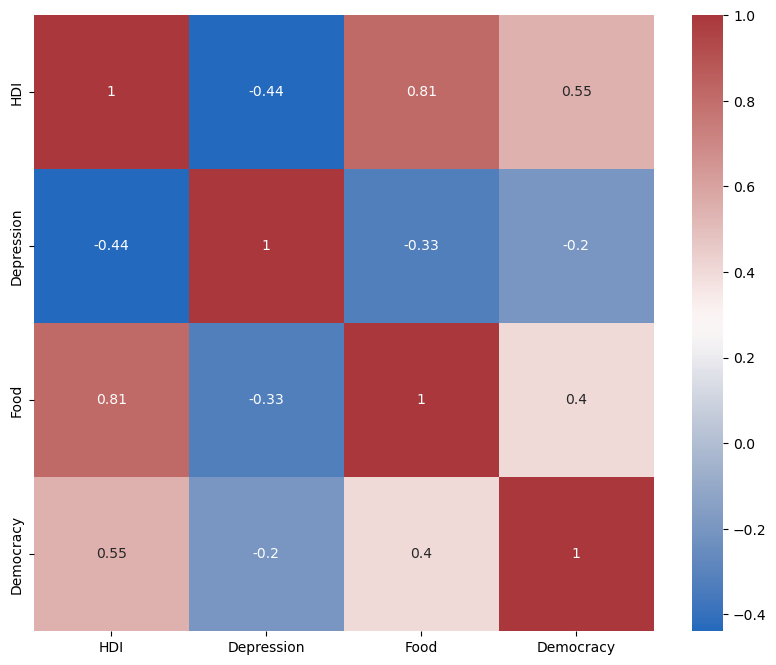

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

x_mx = merge.drop(columns=['Country'])
corr_mx = x_mx.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mx,
            cmap='vlag', 
            annot=True)
plt.show()

In [18]:
import altair as alt

# Individual box plots for each variable
bp_depression = alt.Chart(merge).mark_boxplot().encode(
    y=alt.Y('Depression:Q', title='Prevalence of Depression')
).properties(
    title='Depression',
    width = 250
)

bp_food = alt.Chart(merge).mark_boxplot().encode(
    y=alt.Y('Food:Q', title='Daily Supply of Calories')  # Log scale due to high range
).properties(
    title='Food',
    width = 250
)

bp_democracy = alt.Chart(merge).mark_boxplot().encode(
    y=alt.Y('Democracy:Q', title='Measure of Democracy')
).properties(
    title='Democracy',
    width = 250
)

bp_hdi = alt.Chart(merge).mark_boxplot().encode(
    y=alt.Y('HDI:Q', title='Human Development Index')
).properties(
    title='HDI',
    width = 250
)

# combine
combined_boxplots = bp_depression | bp_food | bp_democracy | bp_hdi

# display
combined_boxplots


alt.HConcatChart(...)

We can identify an outlier based on default parameters in the *Depression* boxplot. This means it is outside the Q3 + 1.5 * IQR range. IQR = Q3 - Q1 and Q1 = .25th percentile / Q3 = .75th percentile.

We can try and find this country on the scatter plot

In [19]:
# find the country with the highest depression prevalence
max_depression = merge[merge['Depression'] == merge['Depression'].max()]['Country'].values[0]

print(max_depression)

Uganda


In [20]:
# create a text layer for the country with most depression
text = alt.Chart(merge[merge['Country'] == max_depression]).mark_text(
    align='left', # text alignment
    dx=7 # moves to the right slightly
).encode(
    x=alt.X('Depression:Q'),
    y=alt.Y('HDI:Q'),
    text='Country'
)

# layer the plots
max_depression_scatter = scatter1 + text

# display
max_depression_scatter

alt.LayerChart(...)

### 3.3 Exploratory Analysis (Categorical Response Variable)

We can turn HDI into a categorical variable in the code below and run different exploratory analyses on it. This allows us to compare/contrast regression and classification using the same dataset and notebook. 

In [21]:
# make a copy of merge that we can edit to have categorical outcome variable     
merge_cat = merge.copy()

# separate HDI into a factor variable
hdi_labels = ['1_low', '2_medium', '3_high']

# pd.qcut() creates quantiles
merge_cat['HDI_fac'] = pd.qcut(merge_cat.HDI,
                               q = 3,
                               labels = hdi_labels)

merge_cat.drop(columns=['HDI'], inplace=True)

# preview
merge_cat.head()

,Country,Depression,Food,Democracy,HDI_fac
0,Afghanistan,4.945168,2040.0,0.082,1_low
1,Albania,2.460203,3360.0,0.484,2_medium
2,Algeria,4.129681,3322.0,0.281,2_medium
3,Angola,5.744194,2385.0,0.344,1_low
4,Argentina,2.407510,3307.0,0.823,3_high


In [22]:
import altair as alt

box1 = alt.Chart(merge_cat).mark_boxplot().encode(
    x='HDI_fac:O',
    y='Depression:Q',
    color='HDI_fac:N'
).properties(
    title='Box plot of Depression by HDI Category',
    width=300
)

box2 = alt.Chart(merge_cat).mark_boxplot().encode(
    x='HDI_fac:O',
    y='Food:Q',
    color='HDI_fac:N'
).properties(
    title='Box plot of Food by HDI Category',
    width=300
)

box3 = alt.Chart(merge_cat).mark_boxplot().encode(
    x='HDI_fac:O',
    y='Democracy:Q',
    color='HDI_fac:N'
).properties(
    title='Box plot of Democracy by HDI Category',
    width=300
)

box1 | box2 | box3

alt.HConcatChart(...)

In [23]:
# attempt at a 4 variable plot (not highly recommended)
alt.Chart(merge_cat).mark_circle().encode(
    x='Depression:Q',
    y='Food:Q',
    color='HDI_fac:N',
    size='Democracy:Q'
).facet(
    column='HDI_fac:O'
).properties(
    title='Scatter plot of Depression, Food, and Democracy by HDI Category'
)


alt.FacetChart(...)

While not the most interpretable plot, this does allow you to examine the relationship between all variables at once.

In [24]:
# bar plots of the means are typically the most interpretable
alt.Chart(merge_cat).mark_bar().encode(
    x='HDI_fac:O',
    y='mean(Depression):Q',
    color='HDI_fac:N'
).properties(
    title='Bar Plot of HDI/Depression',
    width=300
)


alt.Chart(...)

### 3.4 Summary Statistics

In [25]:
merge.describe()

,HDI,Depression,Food,Democracy
count,157.000000,157.000000,157.000000,157.000000
mean,0.723051,3.750438,2880.524838,0.525994
std,0.152134,0.864993,464.642827,0.252601
min,0.394000,2.091181,1786.000000,0.016000
25%,0.597000,3.079915,2551.000000,0.295000
50%,0.740000,3.694577,2857.000000,0.551000
75%,0.842000,4.375998,3301.000000,0.771000
max,0.962000,6.584519,3885.000000,0.916000


In [26]:
# these will be evenly distributed because we used qcut()
merge_cat.HDI_fac.value_counts()

1_low       53
2_medium    52
3_high      52
Name: HDI_fac, dtype: int64

In [27]:
# we saw this earlier but here it is as a table
corr_mx

,HDI,Depression,Food,Democracy
HDI,1.000000,-0.439240,0.810395,0.548158
Depression,-0.439240,1.000000,-0.326157,-0.202256
Food,0.810395,-0.326157,1.000000,0.399234
Democracy,0.548158,-0.202256,0.399234,1.000000


## 4 Regression Models 

The first model we will try is the simplest, just to get an easy and interpretable model to work with.

### 4.1 Preparing Train/Test Sets

In [28]:
# define the predictors and response variable
X = merge[['Depression', 'Food', 'Democracy']]
y = merge['HDI']


In [29]:
from sklearn.model_selection import train_test_split

# split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=805)

#### 4.1.1 Data Scaling

We need to scale our data because our predictors are on different scales. Depression is a percentage (1-100), Food is a daily caloric value (~1700-~3800) and Democracy is a decimal score (0-1). This allows for better interpretability with the coefficients. Data scaling can also speed up convergence of more complex models (makes virtually no difference when using simple linear models like we are now).

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # transform() inherits the scaling from fit_transform()

### 4.2 Multi-Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

# create and fit the model
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
# make predictions on the test set
y_pred = mlr.predict(X_test_scaled)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

Mean Absolute Error: 0.07362594936215394
Root Mean Squared Error: 0.08761958803612005
R-squared: 0.6067931052687864


**Interpreting Performance Metrics**

- **MAE:** The average of the absolute difference between actual and predicted. Gives the average of the residuals in model's predictions. Thus, our prediction of HDI is off by $0.07$ on average. You want to see a lower MAE.

- **RMSE:** The root of the square of the residuals. Tells us the standard deviation of the residuals (i.e. how much do our results vary). Lower RMSE is good, our residuals have a standard deviation of $0.088$.

- **R-Squared:** The percentage of variance explained by our model. We have a moderate fit at $60.68\%$.

In [34]:
coeff_df = pd.DataFrame(mlr.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

intercept = mlr.intercept_
print(f'Intercept: {intercept}')

            Coefficient
Depression    -0.030414
Food           0.105704
Democracy      0.034096
Intercept: 0.7270400000000001


The coefficients tell us how much the outcome variable will change for every one unit increase of a predictor variable. Unfortunately since we had to scale our data, this means we can't just plug in values, we'd have to scale them beforehand OR make two datasets with a one unit difference and observed the change in HDI.

The full formula would look like this:
$$-0.03x_1+0.106x_2+0.0341x_3+0.727=\text{HDI}$$

We will now look into machine learning methods to see if we can improve performance at all.

In [35]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

alt.Chart(predictions).mark_circle().encode(
    x='Actual',
    y='Predicted'
).properties(
    title='Actual vs Predicted HDI'
)

alt.Chart(...)

In [36]:
coefficients = pd.DataFrame({'Variable': ['Depression', 'Food', 'Democracy'], 'Coefficient': mlr.coef_})

coef_plot = alt.Chart(coefficients).mark_bar().encode(
    x = alt.X(
        'Coefficient:Q', 
        title='Coefficient'
        ),
    y = alt.Y(
        'Variable:O', 
        title='Variable', 
        sort=None
        ),
    color=alt.Color(
        'Coefficient:Q',
        scale=alt.Scale(scheme='redblue', domainMid=0) #domainMid=0 centers the color scale at 0
    )
).properties(
    title='Coefficients'
)

coef_plot

alt.Chart(...)

### 4.2 Machine Learning Regression Pipelines

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


In [38]:
# define models as a dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR()
}

# empty dictionary to models results
results = {}

**Note:** There are other ways to create a modeling pipeline, however, using a dictionary is more modular as it allows you to access the models after they've been trained (Calling fit on a dictionary object modifies the actual object rather than the copy).

In [39]:
# use a loop to iterate over models
for name, model in models.items():

    model.fit(X_train_scaled, y_train) # fit the model on SCALED training data

    y_pred = model.predict(X_test_scaled) # make predictions on SCALED test data
    
    # store results
    results[name] = {
        'R-squared': r2_score(y_test, y_pred),
        'Root Mean Square Error': mean_squared_error(y_test, y_pred, squared=False)
    }

# print
for name, metrics in results.items():
    print(f'Model: {name}')
    for metric_name, metric_value in metrics.items():
        print(f'{metric_name}: {metric_value}')
    print('---------------------')

Model: Linear Regression
R-squared: 0.6067931052687864
Root Mean Square Error: 0.08761958803612005
---------------------
Model: Ridge
R-squared: 0.6079759777978622
Root Mean Square Error: 0.0874876970787954
---------------------
Model: Lasso
R-squared: -0.019618050121264163
Root Mean Square Error: 0.14109427823267676
---------------------
Model: Random Forest
R-squared: 0.6964253224516731
Root Mean Square Error: 0.07698806705425204
---------------------
Model: Gradient Boosting
R-squared: 0.6149589745008635
Root Mean Square Error: 0.08670500095960647
---------------------
Model: Support Vector Regressor
R-squared: 0.6279057783492374
Root Mean Square Error: 0.0852348316308298
---------------------


In [40]:
# 'results' is a dictionary with little dictionaries inside it
results

{'Linear Regression': {'R-squared': 0.6067931052687864,
  'Root Mean Square Error': 0.08761958803612005},
 'Ridge': {'R-squared': 0.6079759777978622,
  'Root Mean Square Error': 0.0874876970787954},
 'Lasso': {'R-squared': -0.019618050121264163,
  'Root Mean Square Error': 0.14109427823267676},
 'Random Forest': {'R-squared': 0.6964253224516731,
  'Root Mean Square Error': 0.07698806705425204},
 'Gradient Boosting': {'R-squared': 0.6149589745008635,
  'Root Mean Square Error': 0.08670500095960647},
 'Support Vector Regressor': {'R-squared': 0.6279057783492374,
  'Root Mean Square Error': 0.0852348316308298}}

### 4.3 Accessing Pipeline Models

Let's say we wanted to see the feature importances from the Random Forest model. We can do that below.

In [41]:
# grab the model from the models dictionary
random_forest_model = models['Random Forest']

In [42]:
# store the feature importances
rf_feature_importances = random_forest_model.feature_importances_

# preview
rf_feature_importances


array([0.13962192, 0.69321616, 0.16716193])

In [43]:
# store in a dataframe for easier viewing
features_df = pd.DataFrame(
    {
    'Feature': X.columns,
    'Importance': rf_feature_importances
    }
    ).sort_values(by='Importance', ascending=False)

print(features_df)

      Feature  Importance
1        Food    0.693216
2   Democracy    0.167162
0  Depression    0.139622


### 4.4 What Happened to Lasso?

You may have noticed the Lasso regression model *severely* underperformed (it had a negative $R^2$ score) Let's try and fix it.

In [44]:
from sklearn.model_selection import GridSearchCV

# define a range of values to see if we can improve
# the default alpha for Lasso() is 1.0
alpha_values = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# searches for the best alpha value from the ones provided
grid_search = GridSearchCV(Lasso(), alpha_values, cv=5)

# still need to fit to our scaled data
grid_search.fit(X_train_scaled, y_train)
best_alpha = grid_search.best_params_['alpha']

# print
print(f'Best alpha value: {best_alpha}')


Best alpha value: 0.001


side note: $cv=5$ splits the data into 5 "folds". This is called Cross-Validation. The model is trained on k-1 folds and tested on the excluded fold. This is repeated k-times, which means all folds had a chance to be treated as the test data. The performance from all k processes is averaged to give a single measure.

So the total number of models trained by the code above is $k \times m$. Where $cv = 5 = k$ and $m = 7$ (number of hyperparameters provided).

$m$ is just all possible combinations of the hyperparameters. So if you had two hyperparameters, each with 6 possible values, then the total models trained would be $(6 \times 6) \times k$. 

We notice that the optimal alpha value is 0.001. Perhaps this can fix our model.

In [45]:
# train a new Lasso model using the best alpha value
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

y_pred = lasso_best.predict(X_test_scaled)

# print performance metrics for the new model
print(f'R-squared: {r2_score(y_test, y_pred)}')
print(f'Root Mean Square Error: {mean_squared_error(y_test, y_pred, squared=False)}')


R-squared: 0.6082588464739689
Root Mean Square Error: 0.08745612759138932


We can see that R-Squared and RMSE improved. It appears the default alpha value was holding back our previous model.

### 4.5 Other Hyperparamter Tuning

Since we were able to improve Lasso so much through hyperparameter tuning, perhaps we can improve our other models as well. 

In [49]:
# we need yet another dictionary
hyperparameters = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40]
    },
    'Gradient Boosting': {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.1, 1, 10]
    },
    'Support Vector Regressor': {
        'C': [0.01, 0.1, 1, 10],
        'epsilon': [0.01, 0.1, 1, 10]
    }
}

# empty dictionary for models
best_models = {}

# empty dictionary for results
results_cv = {}

In [50]:
hyperparameters['Random Forest']

{'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30, 40]}

In [51]:
# iterate through the models
for name, model in models.items():
    # loop for if hyperparameters exist
    if name in hyperparameters:
        
        grid_search = GridSearchCV(model, hyperparameters[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        # store the best model
        best_models[name] = grid_search.best_estimator_

        # make predictions with the best model
        y_pred = grid_search.best_estimator_.predict(X_test_scaled)

        # save best params
        best_parameters = grid_search.best_params_

    else:
        # if no hyperparameters were set
        model.fit(X_train_scaled, y_train)
        best_models[name] = model
        y_pred = model.predict(X_test_scaled)
        best_parameters = {}
    
    
    # store results
    results_cv[name] = {
        'R-squared': r2_score(y_test, y_pred),
        'Root Mean Square Error': mean_squared_error(y_test, y_pred, squared=False),
        'Optimal Hyperparameters': best_parameters
    }

/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weig

In [52]:
# print
for name, metrics in results_cv.items():
    print(f'Model: {name}')
    for metric_name, metric_value in metrics.items():
        if metric_name == 'Optimal Hyperparameters':
            print(f'{metric_name}: {metric_value}')   # consider formatting decimal
        else:
            print(f'{metric_name}: {metric_value}')
    print('---------------------')

Model: Linear Regression
R-squared: 0.6067931052687864
Root Mean Square Error: 0.08761958803612005
Optimal Hyperparameters: {}
---------------------
Model: Ridge
R-squared: 0.6079759777978622
Root Mean Square Error: 0.0874876970787954
Optimal Hyperparameters: {'alpha': 1}
---------------------
Model: Lasso
R-squared: 0.6082588464739689
Root Mean Square Error: 0.08745612759138932
Optimal Hyperparameters: {'alpha': 0.001}
---------------------
Model: Random Forest
R-squared: 0.6998191997714469
Root Mean Square Error: 0.07655650528999534
Optimal Hyperparameters: {'max_depth': 10, 'n_estimators': 200}
---------------------
Model: Gradient Boosting
R-squared: 0.6634604195626742
Root Mean Square Error: 0.08106039565238014
Optimal Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 200}
---------------------
Model: Support Vector Regressor
R-squared: 0.6029005611390943
Root Mean Square Error: 0.08805221419681768
Optimal Hyperparameters: {'C': 0.1, 'epsilon': 0.01}
---------------------


In [53]:
# for comparison, our results without GridSearchCV
for name, metrics in results.items():
    print(f'Model: {name}')
    for metric_name, metric_value in metrics.items():
        print(f'{metric_name}: {metric_value}')
    print('---------------------')

Model: Linear Regression
R-squared: 0.6067931052687864
Root Mean Square Error: 0.08761958803612005
---------------------
Model: Ridge
R-squared: 0.6079759777978622
Root Mean Square Error: 0.0874876970787954
---------------------
Model: Lasso
R-squared: -0.019618050121264163
Root Mean Square Error: 0.14109427823267676
---------------------
Model: Random Forest
R-squared: 0.6964253224516731
Root Mean Square Error: 0.07698806705425204
---------------------
Model: Gradient Boosting
R-squared: 0.6149589745008635
Root Mean Square Error: 0.08670500095960647
---------------------
Model: Support Vector Regressor
R-squared: 0.6279057783492374
Root Mean Square Error: 0.0852348316308298
---------------------


# 5 Classification Models

Now that we've seen how to apply model building methods to regression models, we can move onto the same process but for classification models. We will be using the alternative dataset we created earlier when we split the Y variable (HDI) into a factor. 

## 5.1 Prepare Train/Test Sets

In [54]:
# define the predictors and response variable
X_cat = merge_cat[['Depression', 'Food', 'Democracy']]
y_cat = merge_cat['HDI_fac']

In [55]:
# split data into train/test
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=805)

Just appending `cat_` to everything so we don't lose the variables we created earlier

### 5.1.1 Data Scaling

Same as before

In [56]:
scaler_cat = StandardScaler()

X_train_scaled_cat = scaler_cat.fit_transform(X_train_cat)
X_test_scaled_cat = scaler_cat.transform(X_test_cat) # transform() inherits the scaling from fit_transform()

## 5.2 Logistic Regression

This step is slightly different, only because multi-linear regression doesn't work when the variable we are trying to predict is categorical. We will have to use logistic regression.

Typically, if it has the word "regression" in it, it means the model is intended for use with numerical Y variable. The exception to this is the term "logistic regression", which I'm sure there's a good reason why the word regression is in there but it is for classification. 

In [58]:
from sklearn.linear_model import LogisticRegression

# create and fit the model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled_cat, y_train_cat) # you do not need to scale Y dataset

LogisticRegression()

In [59]:
# make predictions on the test set
y_pred_cat = log_reg.predict(X_test_scaled_cat)

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# print classification metrics
print(f'Accuracy: {accuracy_score(y_test_cat, y_pred_cat)}')
print(f'Precision: {precision_score(y_test_cat, y_pred_cat, average="weighted")}') # add average="weighted" if classes are imbalanced
print(f'Recall: {recall_score(y_test_cat, y_pred_cat, average="weighted")}')       # our classes aren't imbalanced but we can add it anyways
print(classification_report(y_test_cat, y_pred_cat))

Accuracy: 0.6875
Precision: 0.6932091346153846
Recall: 0.6875
              precision    recall  f1-score   support

       1_low       0.69      0.75      0.72        12
    2_medium       0.55      0.55      0.55        11
      3_high       0.88      0.78      0.82         9

    accuracy                           0.69        32
   macro avg       0.70      0.69      0.70        32
weighted avg       0.69      0.69      0.69        32



**Interpreting Metrics for Classification Models**

- **Accuracy:** Simply the percentage of correct classifications
- **Precision:** Measure of how accurate the model is when predicts a positive class for any given class. For example, when the model predicts "Low HDI", how many of those predictions are actually low HDI? This measure is calculated for all classes, weighted by class size, then averaged. $\frac{\text{TP}}{\text{TP}+\text{FP}}$
- **Recall:** Measure of correctly labeled classes for a given class. For example, if there are 50 Low HDI rows in the test set, and the model predicts only 40 rows, then there are 10 rows that were a false negative. Recall for that class would be $\frac{40}{(40+10)}$ or $\frac{\text{TP}}{\text{TP}+\text{FN}}$

In [61]:
# coefficients and intercept
coeff_df = pd.DataFrame(log_reg.coef_[0], X_cat.columns, columns=['Coefficient']) # Assuming binary classification
print(coeff_df)

intercept = log_reg.intercept_[0] # For multi-class, log_reg.intercept_ will have multiple values
print(f'Intercept: {intercept}')

            Coefficient
Depression     0.676378
Food          -2.028178
Democracy     -0.439062
Intercept: -0.2711041560579597


### 5.2.1 Quick Explanation of Logistic Regression Coefficients

This is not super important since you will probably never have to do logistic regression by hand, but I included it anyways.

In [63]:
# log_reg.coef_ is a 2D numpy array with shape (n_classes, n_features)
coefficients = pd.DataFrame(log_reg.coef_, columns=X_cat.columns, index=[f'HDI_{c}' for c in log_reg.classes_])


intercepts = pd.Series(log_reg.intercept_, index=[f'HDI_{c}' for c in log_reg.classes_])

# Printing coefficients and intercepts for each class
print(coefficients)
print(f'\nIntercepts: \n{intercepts}')

              Depression      Food  Democracy
HDI_1_low       0.676378 -2.028178  -0.439062
HDI_2_medium   -0.325109 -0.124947  -0.225631
HDI_3_high     -0.351269  2.153126   0.664693

Intercepts: 
HDI_1_low      -0.271104
HDI_2_medium    0.733423
HDI_3_high     -0.462319
dtype: float64


There are three sets of coefficients because the model breaks down the multi-class problem into multiple binary classification problems. For each class, the model creates one binary classifier that tries to distinguish that particular class from all the others. If you have three classes, you end up with three mini-models inside your overall model, each with its own set of coefficients for deciding if an observation belongs to its respective class or not.

An example of one of those mini-models:


$\log\left(\frac{P(\text{HDI\_low})}{P(\text{Not HDI\_low})}\right) = 0.676378 \times \text{Depression} - 2.028178 \times \text{Food} - 0.439062 \times \text{Democracy} - 0.271104$


## 5.3 Machine Learning Classification Pipelines

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # decided to remove this later, pointless when we have Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [65]:
# define models as a dictionary 
models_cat = {
    'Logistic Regression': LogisticRegression(),
    'Ridge Classifier': RidgeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Support Vector Classifier': SVC()
}

# empty dictionary to store results
results_cat = {}

In [66]:
# use a loop to iterate over models
for name, model in models_cat.items():

    model.fit(X_train_scaled_cat, y_train_cat) # fit the model on SCALED training data

    y_pred = model.predict(X_test_scaled_cat) # make predictions on SCALED test data
    
    # store results
    results_cat[name] = {
        'Accuracy': accuracy_score(y_test_cat, y_pred),
        'Precision': precision_score(y_test_cat, y_pred, average='weighted'),
        'Recall': recall_score(y_test_cat, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test_cat, y_pred, average='weighted')
    }

# print
for name, metrics in results_cat.items():
    print(f'Model: {name}')
    for metric_name, metric_value in metrics.items():
        print(f'{metric_name}: {metric_value:.4f}')
    print('---------------------')

/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Model: Logistic Regression
Accuracy: 0.6875
Precision: 0.6932
Recall: 0.6875
F1 Score: 0.6891
---------------------
Model: Ridge Classifier
Accuracy: 0.6875
Precision: 0.6835
Recall: 0.6875
F1 Score: 0.6619
---------------------
Model: K-Nearest Neighbors
Accuracy: 0.7188
Precision: 0.7414
Recall: 0.7188
F1 Score: 0.7253
---------------------
Model: Random Forest Classifier
Accuracy: 0.6250
Precision: 0.6268
Recall: 0.6250
F1 Score: 0.6248
---------------------
Model: Gradient Boosting Classifier
Accuracy: 0.6875
Precision: 0.7512
Recall: 0.6875
F1 Score: 0.6944
---------------------
Model: Support Vector Classifier
Accuracy: 0.7188
Precision: 0.7159
Recall: 0.7188
F1 Score: 0.7164
---------------------


In [67]:
results_cat

{'Logistic Regression': {'Accuracy': 0.6875,
  'Precision': 0.6932091346153846,
  'Recall': 0.6875,
  'F1 Score': 0.6891176470588235},
 'Ridge Classifier': {'Accuracy': 0.6875,
  'Precision': 0.6834935897435896,
  'Recall': 0.6875,
  'F1 Score': 0.6618783422459893},
 'K-Nearest Neighbors': {'Accuracy': 0.71875,
  'Precision': 0.741386217948718,
  'Recall': 0.71875,
  'F1 Score': 0.7253328804347826},
 'Random Forest Classifier': {'Accuracy': 0.625,
  'Precision': 0.6268028846153846,
  'Recall': 0.625,
  'F1 Score': 0.6247794117647059},
 'Gradient Boosting Classifier': {'Accuracy': 0.6875,
  'Precision': 0.7511817226890756,
  'Recall': 0.6875,
  'F1 Score': 0.6944196428571429},
 'Support Vector Classifier': {'Accuracy': 0.71875,
  'Precision': 0.7158653846153846,
  'Recall': 0.71875,
  'F1 Score': 0.7164285714285713}}

Looks like SVC and KNN are the top performers of this dataset. Random Forest is underperforming, which isn't very characteristic. This could be fixed with hyperparameter tuning.

## 5.4 Hyperparameter Tuning All Classification Models

In [70]:
# define hyperparameters for classification models
hyperparameters_cat = {
    'Ridge Classifier': {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11]
    },
    'Random Forest Classifier': {
        'n_estimators': [5, 10, 25, 50, 100],
        'max_depth': [None, 5, 10, 20, 30, 40]
    },
    'Gradient Boosting Classifier': {
        'n_estimators': [5, 10, 25, 50, 100],
        'learning_rate': [0.001, 0.01, 0.1, 1, 10]
    },
    'Support Vector Classifier': {
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly']
    }
}

# empty dictionary for storing models
best_models_cat = {}

# empty dictionary for storing results
results_cv_cat = {}

In [71]:
# display hyperparams of one model
hyperparameters_cat['Random Forest Classifier']

{'n_estimators': [5, 10, 25, 50, 100], 'max_depth': [None, 5, 10, 20, 30, 40]}

In [72]:
# iterate over models
for name, model in models_cat.items():
    # loop for if hyperparameters exist
    if name in hyperparameters_cat:
        
        grid_search = GridSearchCV(model, hyperparameters_cat[name], cv=5)
        grid_search.fit(X_train_scaled_cat, y_train_cat)
        
        # store the best model
        best_models_cat[name] = grid_search.best_estimator_

        # make predictions with the best model
        y_pred = grid_search.best_estimator_.predict(X_test_scaled_cat)

        # store the optimal hyperparameters
        best_parameters = grid_search.best_params_

    else:
        # if no hyperparameters were defined, fit the model as is
        model.fit(X_train_scaled_cat, y_train_cat)
        best_models_cat[name] = model
        y_pred = model.predict(X_test_scaled_cat)
        best_parameters = {}

    # store results with classification metrics
    results_cv_cat[name] = {
        'Accuracy': accuracy_score(y_test_cat, y_pred),
        'Precision': precision_score(y_test_cat, y_pred, average='weighted'),
        'Recall': recall_score(y_test_cat, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test_cat, y_pred, average='weighted'),
        'Optimal Hyperparameters': best_parameters
    }


/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/krish/opt/anaconda3/envs/p1/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

In [73]:
# print the results
for name, metrics in results_cv_cat.items():
    print(f'Model: {name}')
    for metric_name, metric_value in metrics.items():
        if metric_name == 'Optimal Hyperparameters':
            print(f'{metric_name}: {metric_value}')
        else:
            print(f'{metric_name}: {metric_value:.4f}')  # Format to 4 decimal places
    print('---------------------')

Model: Logistic Regression
Accuracy: 0.6875
Precision: 0.6932
Recall: 0.6875
F1 Score: 0.6891
Optimal Hyperparameters: {}
---------------------
Model: Ridge Classifier
Accuracy: 0.6875
Precision: 0.6835
Recall: 0.6875
F1 Score: 0.6619
Optimal Hyperparameters: {'alpha': 0.001}
---------------------
Model: K-Nearest Neighbors
Accuracy: 0.7188
Precision: 0.7414
Recall: 0.7188
F1 Score: 0.7253
Optimal Hyperparameters: {'n_neighbors': 5}
---------------------
Model: Random Forest Classifier
Accuracy: 0.5625
Precision: 0.5818
Recall: 0.5625
F1 Score: 0.5700
Optimal Hyperparameters: {'max_depth': None, 'n_estimators': 25}
---------------------
Model: Gradient Boosting Classifier
Accuracy: 0.7188
Precision: 0.7381
Recall: 0.7188
F1 Score: 0.7200
Optimal Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
---------------------
Model: Support Vector Classifier
Accuracy: 0.7500
Precision: 0.7645
Recall: 0.7500
F1 Score: 0.7543
Optimal Hyperparameters: {'C': 10, 'kernel': 'linear'}
------

I'm noticing that performance actually got worse for some models. This may have to do with the overfitting problem we talked about. I think there are ways to improve on the cross-validation method used that I've seen before. I'm not entirely sure how to do it but we can look into it.